# Projet Maths-Info 3 Horsin Cattan

## Projet Numérique : câble sous-marin


### Questions théoriques

1. La loi faibles des grands nombres montre que pour un très grand nombre d'expériences, la moyennes des résultats tend vers l'espérence de la variable aléatoire.



2. On reprend les notations de l'énoncé. Quitte à réindicer les variables, on suppose que : <br> $\exists 1 \leq k<n$ , tel que on souhaite trouver la loi de Z sachant que $Y=({Z_{j1}},...,{Z_{jk}})$ <br>
Ainsi, les composantes de Z sont les variables alétoires associés aux profondeurs inconnues, rangées par ordre croissant. <br>La loi conditionelle du vecteur des composantes de Z, connaissant les valeurs prises par les compososantes aux sites d'observation est donc, d'après le cours proba 4 une loi normale de moyenne m_z et de matrice de covariance CS_z, dont les formules sont fournies dans le cours:

$$
CS_{Z}=C_{Z}-C_{Z, Y} C_{Y}^{-1} C_{Y, Z}
$$


$$
m_{Z| Y=y}=m_{Z}-C_{Z,Y} C_{Y}^{-1}\left(Y-m_{Y}\right)
$$

avec, en notant C la matrice de Covariance de la variable aléatoire T=(Z,Y):

$$
C=\left(\begin{array}{ll}
{C_{Z}} & {C_{Z,Y}} \\
{C_{Y,Z}} & {C_{Y}}
\end{array}\right)
$$







3. Si Y est un vecteur de composantes gausiennes indépendantes, toutes d'espérance nulle et de variance 1, alors 
le vecteur Z tel Z=m+RY est un vecteur gaussien, d'espérence m et de matrice de Covariance R. (résulatat du cours proba 5).



4. Ainsi, pour effectuer une simulation conditionnelle, on va utiliser le module random, et plus particulièrement la méthode random.random(), qui simule le résultat d'un variable aléatoire U suivant une loi unifome sur l'intervalle ouvert $]0,1[$ <br>Puis d'après le cours, à partir de cette variable aléatoire, on peut simuler une loi normale centrée reduite en posant $X=\sqrt{-2ln(U)}$cos(2$\pi$U).<br> On repéte l'opération N-k fois avec k le nombre de profondeurs observées, ce qui permet de créer un vecteur T, composés de N-k variables aléatoires indépendantes suivant des lois normales centrées réduites. On obtient ensuite le vecteur Z, resultat d'une simulation, qui contient les résultats des N-k profondeurs inconnues, en posant $Z=m_{z}+LT$ avec $m_{z}$ l'espérence conditonnelle de Z sachant Y, et L la décomposotion de Cholesky de la matrice de covariance conditionelle. (La démonstration des résultats se trouve dans le cours du chapitre proba 5.)




In [1]:
###Implémentation

#Chargement de dépendances
import numpy as np
import math
import matplotlib.pyplot as plt
import random as rd

#Discrétisation
A=0
B=500
N=101 #Nombre de points de discrétisayion
Delta = (B-A)/(N-1)
discretization_indexes=np.arange(N)
discretization=discretization_indexes*Delta

#Paramètres du modèle

mu=-5
a=50
sigma2=12

#Données

observation_indexes= [0,20,40,60,80,100]
depth=[0,-4,-12.8,-1,-6.5,0]

unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))

## Questions

In [2]:
###Question 1###
#fonction utile pour le calcul de covariance

def calcul_covariance(mat_distance):
    return sigma2*np.exp(-mat_distance/a)

#grâce au module numpy, on a une fonction pour les vecteurs et les scalaires

In [3]:
###Question 2###
#matrice des distances

Mat_distance=np.zeros((N,N))
for i in range(N):
    for j in range(N):
        Mat_distance[i][j]=np.abs(discretization[i]-discretization[j])

        
print(Mat_distance)
#On remarque que la matrice est bien symétrique, réelle, positive.

[[  0.   5.  10. ... 490. 495. 500.]
 [  5.   0.   5. ... 485. 490. 495.]
 [ 10.   5.   0. ... 480. 485. 490.]
 ...
 [490. 485. 480. ...   0.   5.  10.]
 [495. 490. 485. ...   5.   0.   5.]
 [500. 495. 490. ...  10.   5.   0.]]


In [4]:
###Question 3###
#on applique notre fonction de calcul de la fonction C à la matrice des distances pour 
#avoir la matrice de covariance de Z

Cov_Z=calcul_covariance(Mat_distance)

In [5]:
###Question 4###
#On déduit de la matrice précédente respectivement:
k=len(observation_indexes)


Cov_obs=np.zeros((k,k)) #la matrice de covariance entre les observations
Cov_obs_unknown=np.zeros((N-k,k)) #la matrice de covariance entre les observations et les inconnues
Cov_unknow=np.zeros((N-k,N-k)) #la matrice de covariance entre les inconnues

#pour procéder, on regarde où se trouve chacun des indexs (dans les inconnues ou les observations)

for i in range(k):
    for j in range(k):
        Cov_obs[i][j]=Cov_Z[observation_indexes[i]][observation_indexes[j]]

for i in range(N-k):
    for j in range(N-k):
        Cov_unknow[i][j]=Cov_Z[unknown_indexes[i]][unknown_indexes[j]]

for i in range(N-k):
    for j in range(k):
        Cov_obs_unknown[i][j]=Cov_Z[unknown_indexes[i]][observation_indexes[j]]


In [6]:
###Question 5###
#La variable alétoire conditionnelle est une gaussienne d'espérence conditonnelle notée m_z 
#On calcule m_z avec la formule du cours proba 4.

m_z= np.full(N-k,mu) #vecteur de taille N-k, avec la valeur mu uniquement 
m_y= np.full(k,mu)
Cov_obs_inv=np.linalg.inv(Cov_obs) #on doit inverser la matrice de covariance des observations
y= np.asarray(depth) #résultats des observations
#asarray permet de convertir la liste depth en un vecteur numpy, afin d'effectuer du calcul matriciel

esp_cond = m_z + np.dot(np.dot(Cov_obs_unknown,Cov_obs_inv),y-m_y) #formule du cours



In [7]:
## je crée une fonction intermédiaire
#fonction qui complète un "résultat conditionnelle" (espérence ou résultat) de profondeurs
#à partir des données d'observations pour obtenir un vecteur à N coordonnées

def complete_profondeur(Liste):
    L=[]
    for j in Liste:
        L.append(j)
    for i in range(len(observation_indexes)):
        L.insert(observation_indexes[i],depth[i])
    return L

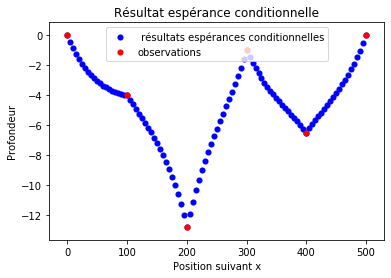

In [8]:
###réalisation du tracé:
plt.xlabel("Position suivant x")
plt.ylabel("Profondeur")
plt.title("Résultat espérance conditionnelle")
plt.scatter(discretization,complete_profondeur(esp_cond),color='b',linewidth="0.1",
            label=' résultats espérances conditionnelles')
plt.scatter(np.asarray(observation_indexes)*5,depth,color='r',linewidth="0.1",label='observations')
plt.legend()
plt.show()

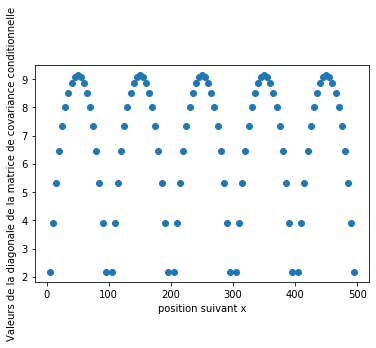

In [9]:
###Question 6###
#on calcule la matrice de Covariance conditionnelle avec la formile du cours proba 4

Cov_cond = Cov_unknow-np.dot(np.dot(Cov_obs_unknown,Cov_obs_inv),np.transpose(Cov_obs_unknown))
V=[]
for i in range(N-k):
    V.append(Cov_cond[i][i])
plt.scatter(np.asarray(unknown_indexes)*5,V)
plt.xlabel("position suivant x")
plt.ylabel("Valeurs de la diagonale de la matrice de covariance conditionnelle")
plt.show()


On remarque que plus l'abscisse x est éloignée d'un point d'observations, plus la covariance conditionelle de la variable aléatoire associé à un point est élevée. Ce qui est logique car on a "de moins en moins d'informations" quand on s'éloigne d'une profondeur observée.
De plus, les termes sont bien positifs car les termes de la diagonale correspondent à la variance des variables aléatoire associé à la profondeur des différentes abscisses.


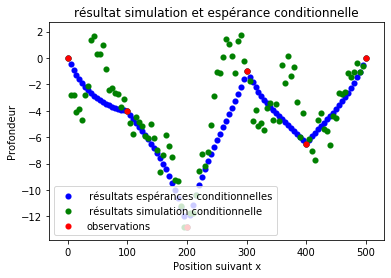

In [10]:
###Question 7###
#On réalise une simulation conditionnelle comme expliqué question théorique n°4

#on arrondie les valeurs dans la matrice car sinon il y'a un soucis de représentation des flottants
H=np.around(Cov_cond,6)

L=np.linalg.cholesky(H) #on applique la décompostion de cholesky à la matrice
#nous avons fait composer deux fois par - car la décomposition est pour les matrices définies positives

X=[]
Z=[]
for u in range(N-k):
    X.append(np.sqrt(-2*np.log(rd.random()))*np.cos(2*np.pi*rd.random()))#loi normale centrée réduite
Z=esp_cond+np.dot(L,X) #Z est le résultat d'une simulation conditionnelle

#On fait le tracé demandé:
plt.xlabel("Position suivant x")
plt.ylabel("Profondeur")
plt.title("résultat simulation et espérance conditionnelle")
plt.scatter(discretization,complete_profondeur(esp_cond),color='b',linewidth="0.1",
            label=' résultats espérances conditionnelles')

plt.scatter(discretization,complete_profondeur(Z),color='g',linewidth="0.1",
            label=' résultats simulation conditionnelle')
plt.scatter(np.asarray(observation_indexes)*5,depth,color='r',linewidth="0.1",label='observations')
plt.legend()
plt.show()


In [11]:
###Question 8###
#on crée une fonction qui calcule la longeur de câble:


def longueur_cable(Liste_prof, pas):
    S=0
    for i in range(len(Liste_prof)-1):
        S+= math.sqrt(pas**2 + (Liste_prof[i+1]-Liste_prof[i])**2)
    return S


In [12]:
###Question 9##
#Pour faciliter le travail et la relecture,
#on va créer une fonction qui prend un nombre n de simulations à réaliser,
#et renvoie les réponses aux différentes questions 9,10,11

def simulation(n):
    Résultats=[]
    for j in range(n):
        X=[]
        Z=[]
        for u in range(N-k):
            X.append(np.sqrt(-2*np.log(rd.random()))*np.cos(2*np.pi*rd.random()))
        Z=esp_cond+np.dot(L,X)
        Résultats.append(Z)

    ### Pour la question 9 ###
    #On calcule la moyenne des longeurs de câble pour les n simulations:
    Moy_longueur=0
    for i in Résultats:
        Moy_longueur+=longueur_cable(complete_profondeur(i),5)#on complete avec toutes les profondeurs et on calcule la longueur
    Moy_longueur=Moy_longueur/n
    
    
    #### Pour la question 10###
    #On va réprésenter la suite Mn des moyennnes des longueurs de câbles:

    M_n=[]
    N_values=[]
    Tot_longueur=0
    Moy_longueur=0
    for r in range(len(Résultats)):
        N_values.append(r+1)
        Tot_longueur+=longueur_cable(complete_profondeur(Résultats[r]),5)#on complete avec toutes les profondeurs et on calcule la longueur
        Moy_longueur=Tot_longueur/(r+1)
        M_n.append(Moy_longueur)
        
        
    ### Pour la question 11###
    #On va réaliser un histogramme des longeurs pour les 100 simulations précédentes:
    Tot_cordes = []
    for i in Résultats:
        Tot_cordes.append(longueur_cable(complete_profondeur(i),5))
        
        
    return [Résultats, Moy_longueur,M_n, N_values, Tot_cordes]



   
    



In [13]:
### Pour 100 simulations:

Résultats_100_Sim=simulation(100)

In [14]:
###Réponse question 9###

Moy_longueur_100_Sim=Résultats_100_Sim[1]


print(f'La moyenne des longueurs pour 100 simulations vaut {Moy_longueur_100_Sim}')
print(f"La longueur de l'espérance conditionnelle vaut {longueur_cable(complete_profondeur(esp_cond),5)}")
   



    

La moyenne des longueurs pour 100 simulations vaut 522.3998053484617
La longueur de l'espérance conditionnelle vaut 501.6468416918411


On remarque que l'espérance conditionnelle estimée n'est pas égale à la longueur de l'espérance conditionnelle de câble. On peut expliquer cela car la longueur de corde n'est pas directement proportionnelle à la profondeur. ALors même si les profondeurs estimées tendent vers l'espérence conditionnelle des profondeurs, ce n'est pas le cas pour les longueurs de câble.

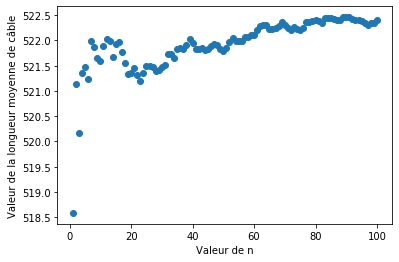

In [15]:
###Réponse question 10###

Suite_M_n_100_Sim=Résultats_100_Sim[2]

Valeur_de_n_100_Sim=Résultats_100_Sim[3]


plt.scatter(Valeur_de_n_100_Sim,Suite_M_n_100_Sim)
plt.xlabel("Valeur de n")
plt.ylabel('Valeur de la longueur moyenne de câble')
plt.show()

Le résultat semble converger vers une valeur situé entre 522,2 et 522,7 m pour la longueur de câble, il est difficile d'avoir une précision supplémentaire.

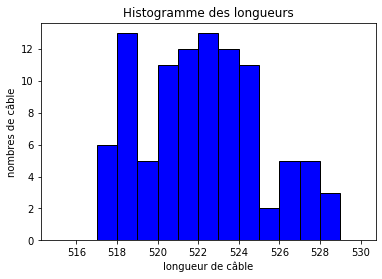

In [16]:
###Réponse question 11###
##On trace l'histogramme souhaité:

Longueurs_des_cables_100_Sim=Résultats_100_Sim[4]

plt.hist(Longueurs_des_cables_100_Sim, range = (515, 530), bins = 15, color = 'blue',
            edgecolor = 'black')
plt.xlabel('longueur de câble')
plt.ylabel('nombres de câble')
plt.title('Histogramme des longueurs')
plt.show()

### Question 12: Méthode 1

On souhaite donner un intervalle de confiance à 95% de la longueur du câble.

On utilise l'inégalité de Bienaymé-Tchebychev.
L'intervalle de confiance à 95% correspond à:

$P(|X-E(X)|\ge \alpha) \le \frac{\sigma^2}{\alpha^2}=\frac{5}{100}$

En inversant la formule, on trouve que:

$L_{0,025}=\mu -\sqrt{\frac{100}{5}}\sigma$ et $L_{0,975}=\mu +\sqrt{\frac{100}{5}}\sigma$

On estime à nouveau l'espérence et l'écart-type à partir des données de la simulation

In [17]:
def calcul_ecart_type(Longueurs_cordes,moy):
    Var=0
    for i in Longueurs_cordes:
        Var+=(i-moy)**2
    
    return math.sqrt(Var/len(Longueurs_cordes))

Ecart_type_100_Sim=calcul_ecart_type(Longueurs_des_cables_100_Sim, Moy_longueur_100_Sim )

In [18]:
Borne_inf_100_Sim = Moy_longueur_100_Sim -math.sqrt(20)*Ecart_type_100_Sim
Borne_sup_100_Sim = Moy_longueur_100_Sim +math.sqrt(20)*Ecart_type_100_Sim


print(f"L'intervalle de confiance à 95% est estimé à [{Borne_inf_100_Sim},{Borne_sup_100_Sim}]")

L'intervalle de confiance à 95% est estimé à [508.3578294490884,536.4417812478349]


### Question 12: Méthode 2

On peut aller plus loin et fair el'hypothèse que:
Considérant la distribution des longueurs des cordes obtenues pour 100 simulations, on peut approximer la variable aléatoire associé à la longueur des cordes comme suivant une loi normale, dont la moyenne a été calculée à la question 9 et dont on peut estimer la variance à l'aide des 100 simulations, puis l'écart-type
Puis, pour une loi Normale, on trouve les deux de l'intervalle de confiance à 95 % grâce à la formule:


$L_{0,025}=\mu -1,96\sigma$ et $L_{0,975}=\mu +1,96\sigma$


In [19]:
Borne_inf_100_Sim = Moy_longueur_100_Sim -1.96*Ecart_type_100_Sim
Borne_sup_100_Sim = Moy_longueur_100_Sim +1.96*Ecart_type_100_Sim


print(f"L'intervalle de confiance à 95% est estimé à [{Borne_inf_100_Sim},{Borne_sup_100_Sim}]")

L'intervalle de confiance à 95% est estimé à [516.2456380691768,528.5539726277465]


Rmq:La deuxième méthode est plus précise mais suppose des hypotèses plus fores, qui seront mieux vérifiés avec un nombre plus grand de simulation.

In [20]:
###Question 13###
#pour estimer la probabilité que la longueur du câble dépasse 525m, on fait beaucoup de simulations (50 000)
#et on approxime la probabilité par le calcul de type(nbre de cas favorable/nombre de simulations)
def calcul_proba(liste_cables):
    Nbre_cas_fav=0
    for i in liste_cables:
        if i>525:
            Nbre_cas_fav+=1
    return Nbre_cas_fav/len(liste_cables)
    
print(f'''La probabilité que la longueur de câble dépasse 525 vaut approximativement {calcul_proba(Longueurs_des_cables_100_Sim):.2f},
Nous avons fait un arrondi au centième
Mais après plusieurs simulations, on obtient un résultat qui varie autour de 0,2
Plus de simulations permet de faire converger le calcul de cette probabilité, et des autres calculs''')
        

La probabilité que la longueur de câble dépasse 525 vaut approximativement 0.17,
Nous avons fait un arrondi au centième
Mais après plusieurs simulations, on obtient un résultat qui varie autour de 0,2
Plus de simulations permet de faire converger le calcul de cette probabilité, et des autres calculs


### Question 14

# Pour 1000,10000 et 100000 simulations

In [21]:
#Pour 1000 simulations

Résultats_1000_Sim=simulation(1000)

Moy_longueur_1000_Sim=Résultats_1000_Sim[1]
Suite_M_n_1000_Sim=Résultats_1000_Sim[2]
Valeur_de_n_1000_Sim=Résultats_1000_Sim[3]
Longueurs_des_cables_1000_Sim=Résultats_1000_Sim[4]



Ecart_type_1000_Sim=calcul_ecart_type(Longueurs_des_cables_1000_Sim, Moy_longueur_1000_Sim)

Borne_inf_1000_Sim_1 = Moy_longueur_1000_Sim -math.sqrt(20)*Ecart_type_1000_Sim
Borne_sup_1000_Sim_1 = Moy_longueur_1000_Sim +math.sqrt(20)*Ecart_type_1000_Sim



Borne_inf_1000_Sim_2 = Moy_longueur_1000_Sim -1.96*Ecart_type_1000_Sim
Borne_sup_1000_Sim_2 = Moy_longueur_1000_Sim +1.96*Ecart_type_1000_Sim

In [22]:
#Pour 10000 simulations

Résultats_10000_Sim=simulation(10000)

Moy_longueur_10000_Sim=Résultats_10000_Sim[1]
Suite_M_n_10000_Sim=Résultats_10000_Sim[2]
Valeur_de_n_10000_Sim=Résultats_10000_Sim[3]
Longueurs_des_cables_10000_Sim=Résultats_10000_Sim[4]



Ecart_type_10000_Sim=calcul_ecart_type(Longueurs_des_cables_10000_Sim, Moy_longueur_10000_Sim)

Borne_inf_10000_Sim_1 = Moy_longueur_10000_Sim -math.sqrt(20)*Ecart_type_10000_Sim
Borne_sup_10000_Sim_1 = Moy_longueur_10000_Sim +math.sqrt(20)*Ecart_type_10000_Sim



Borne_inf_10000_Sim_2 = Moy_longueur_10000_Sim -1.96*Ecart_type_10000_Sim
Borne_sup_10000_Sim_2 = Moy_longueur_10000_Sim +1.96*Ecart_type_10000_Sim

In [23]:
#Pour 100000 simulations

Résultats_100000_Sim=simulation(100000)

Moy_longueur_100000_Sim=Résultats_100000_Sim[1]
Suite_M_n_100000_Sim=Résultats_100000_Sim[2]
Valeur_de_n_100000_Sim=Résultats_100000_Sim[3]
Longueurs_des_cables_100000_Sim=Résultats_100000_Sim[4]



Ecart_type_100000_Sim=calcul_ecart_type(Longueurs_des_cables_100000_Sim, Moy_longueur_100000_Sim)

Borne_inf_100000_Sim_1 = Moy_longueur_100000_Sim -math.sqrt(20)*Ecart_type_100000_Sim
Borne_sup_100000_Sim_1 = Moy_longueur_100000_Sim +math.sqrt(20)*Ecart_type_100000_Sim



Borne_inf_100000_Sim_2 = Moy_longueur_100000_Sim -1.96*Ecart_type_100000_Sim
Borne_sup_100000_Sim_2 = Moy_longueur_100000_Sim +1.96*Ecart_type_100000_Sim

522.4358421639953


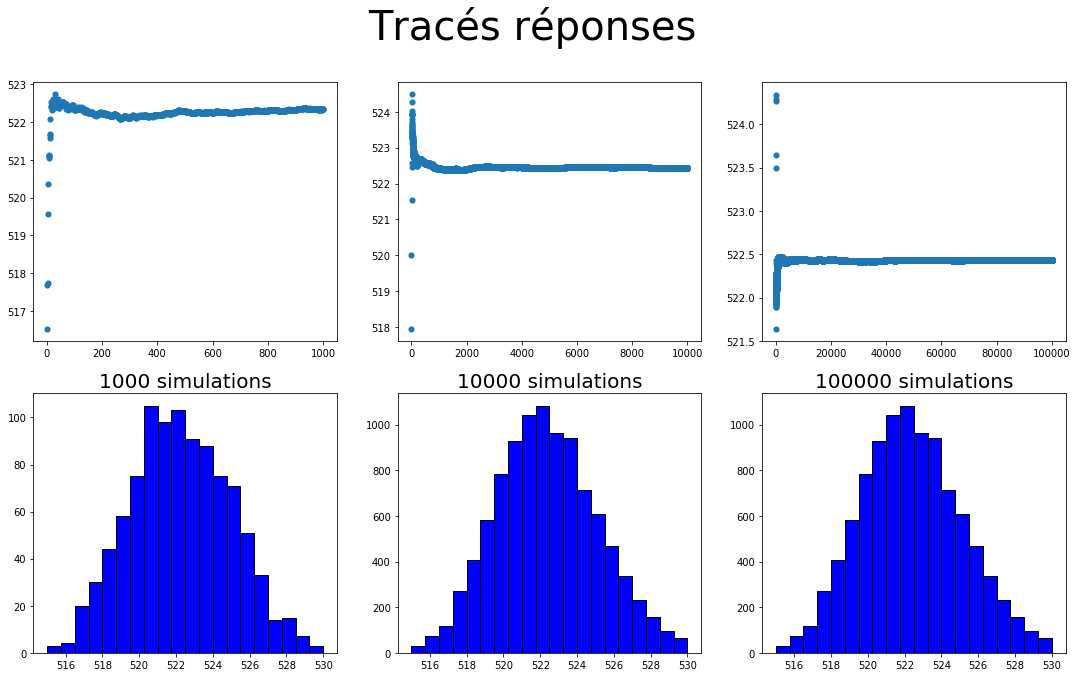

In [24]:
###Les tracés:
fig, axes = plt.subplots(2, 3)
fig.suptitle('Tracés réponses',fontsize=40)
fig.set_size_inches(18.5, 10.5, forward=True)
axes[0,0].scatter(Valeur_de_n_1000_Sim, Suite_M_n_1000_Sim,linewidth=0.1)
axes[0,1].scatter(Valeur_de_n_10000_Sim, Suite_M_n_10000_Sim,linewidth=0.1)
axes[0,2].scatter(Valeur_de_n_100000_Sim, Suite_M_n_100000_Sim,linewidth=0.1)
axes[1,0].hist(Longueurs_des_cables_1000_Sim, range = (515, 530), bins = 20, color = 'blue',
            edgecolor = 'black')
axes[1,1].hist(Longueurs_des_cables_10000_Sim, range = (515, 530), bins = 20, color = 'blue',
            edgecolor = 'black')
axes[1,2].hist(Longueurs_des_cables_10000_Sim, range = (515, 530), bins = 20, color = 'blue',
            edgecolor = 'black')
axes[1,0].set_title(f'1000 simulations',fontsize=20)
axes[1,1].set_title(f'10000 simulations',fontsize=20)
axes[1,2].set_title(f'100000 simulations',fontsize=20)

axes[1,0].set_title(f'1000 simulations',fontsize=20)
axes[1,1].set_title(f'10000 simulations',fontsize=20)
axes[1,2].set_title(f'100000 simulations',fontsize=20)

In [25]:
print(f'La moyenne des longueurs pour 1000 simulations vaut {Moy_longueur_1000_Sim}')
print(f'La moyenne des longueurs pour 10000 simulations vaut {Moy_longueur_10000_Sim}')
print(f'La moyenne des longueurs pour 100000 simulations vaut {Moy_longueur_100000_Sim}')

La moyenne des longueurs pour 1000 simulations vaut 522.3311350448935
La moyenne des longueurs pour 10000 simulations vaut 522.4272260890771
La moyenne des longueurs pour 100000 simulations vaut 522.4358421639953


In [26]:
print(f"L'intervalle de confiance à 95% est estimé à [{Borne_inf_1000_Sim_1},{Borne_sup_1000_Sim_1}]\npar la méthode 1 avec 1000 simulations")
print(f"L'intervalle de confiance à 95% est estimé à [{Borne_inf_10000_Sim_1},{Borne_sup_10000_Sim_1}]\npar la méthode 1 avec 10000 simulations")
print(f"L'intervalle de confiance à 95% est estimé à [{Borne_inf_100000_Sim_1},{Borne_sup_100000_Sim_1}]\npar la méthode 1 avec 10000 simulations")

L'intervalle de confiance à 95% est estimé à [509.57448784392386,535.0877822458631]
par la méthode 1 avec 1000 simulations
L'intervalle de confiance à 95% est estimé à [509.59185528296126,535.2625968951929]
par la méthode 1 avec 10000 simulations
L'intervalle de confiance à 95% est estimé à [509.47137967106596,535.4003046569246]
par la méthode 1 avec 10000 simulations


In [27]:
print(f"L'intervalle de confiance à 95% est estimé à [{Borne_inf_1000_Sim_2},{Borne_sup_1000_Sim_2}]\npar la méthode 2 avec 1000 simulations")
print(f"L'intervalle de confiance à 95% est estimé à [{Borne_inf_10000_Sim_2},{Borne_sup_10000_Sim_2}]\npar la méthode 2 avec 10000 simulations")
print(f"L'intervalle de confiance à 95% est estimé à [{Borne_inf_100000_Sim_2},{Borne_sup_100000_Sim_2}]\npar la méthode 2 avec 10000 simulations")


L'intervalle de confiance à 95% est estimé à [516.7402879048487,527.9219821849382]
par la méthode 2 avec 1000 simulations
L'intervalle de confiance à 95% est estimé à [516.8018768078543,528.0525753702998]
par la méthode 2 avec 10000 simulations
L'intervalle de confiance à 95% est estimé à [516.7539159565117,528.1177683714789]
par la méthode 2 avec 10000 simulations


In [28]:
print(f'''Avec 1000 simulations,
la probabilité que la longueur de câble dépasse 525 vaut approximativement {calcul_proba(Longueurs_des_cables_1000_Sim)}''')

print(f'''Avec 10000 simulations,
la probabilité que la longueur de câble dépasse 525 vaut approximativement {calcul_proba(Longueurs_des_cables_10000_Sim)}''')

print(f'''Avec 100000 simulations,
la probabilité que la longueur de câble dépasse 525 vaut approximativement {calcul_proba(Longueurs_des_cables_100000_Sim)}''')

Avec 1000 simulations,
la probabilité que la longueur de câble dépasse 525 vaut approximativement 0.176
Avec 10000 simulations,
la probabilité que la longueur de câble dépasse 525 vaut approximativement 0.1832
Avec 100000 simulations,
la probabilité que la longueur de câble dépasse 525 vaut approximativement 0.18531


## Conclusion:

Plus on a un grand nombre de simulation, plus on va tendre vers un loi gausienne, d'espérence 522,4 m.
Cette convergence vers la loi gausienne permet de valider l'hypothèse prise dans le calcul de l'intervalle de confiance à 95%.
Pour chaque calcul de la question 9 à 13, on remarque surtout que les valeurs obtenues sont très proches lorsqu'on repète le processus de simulation, ce qui confirme la convergence.

<p>
-Pour la suite M_n, on remarque que pour un grand nombre de simulation, elle converge vers 522,4 m. De plus, on est proche de ce résultat même si on répète de nombreuses fois le processus de simulation.<p>
<p> 
-De meme, pour les valeurs de bornes à 95%, on converge vers l'intervalle [517,528] <p>
    
<p> 
-De meme, pour la probabiloté que le câble dépasse 525m, on converge vers un valeur de 0,185 <p>


